# $Kerithmos$
Identifying numbers using keras
***

## Setup
Here we do all our imports, as well as define any constants we use throughout the notebook.

In [1]:
# from tensorflow.keras import 
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import loadmat
import tensorflow.keras as kr

In [2]:
# consts
DATA_DIR = "../data/"
IMG_DIMS = (32,32,3)
NUM_CLASSES = 10

## Load Data
Now we load the sample data from files and rearrange into appropriate format. Keras expects images in the form (samples,channels,x,y) or (samples,x,y,channels). Given the data is stored (x,y,channels,samples) we will use np.moveaxis to change it to a more conventional (and plotable) format.

In [3]:
kr.backend.set_image_data_format('channels_last') #this should be default, but just in case
train_data = loadmat(DATA_DIR + "train.mat")
test_data = loadmat(DATA_DIR + "test.mat")
X = train_data["X"]
X = np.moveaxis(X, -1, 0)
y = train_data["y"].flatten()-1 # matlab starts arrays at 1
X_test = test_data["X"]
X_test = np.moveaxis(X_test.T, -1, 0)
y_test = test_data["y"].flatten()-1 # matlab starts arrays at 1
X.shape #sanity check

(73257, 32, 32, 3)

Plot a random selection and it's corresponding label:

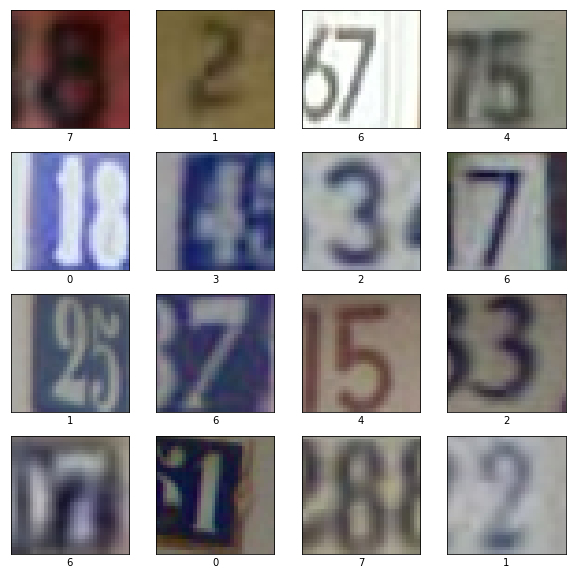

In [4]:
plt.figure(figsize=(10,10))
for i in range(16):
    rnd = np.random.randint(0,X.shape[0])
    plt.subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[rnd])
    plt.xlabel(y[rnd]%10) #data treats 10 as 0
plt.show()

## Preprocess Data

In [5]:
X = X / 255.0
X_test = X_test / 255.0

## Prepare Model

In [6]:
# consts / params
optimizer = 'adam'
loss='sparse_categorical_crossentropy'
metrics=['accuracy']

In [7]:
# a standard MLP
NUM_UNITS = 128
NUM_LAYERS = 4
dense_model = kr.models.Sequential()
dense_model.add(kr.layers.Flatten(input_shape=IMG_DIMS))
# dense_model.add(kr.layers.Dense(NUM_UNITS, input_shape=(32,32,3)))
for n in range(NUM_LAYERS):
    dense_model.add(kr.layers.Dense(NUM_UNITS, activation='relu'))
dense_model.add(kr.layers.Dense(NUM_CLASSES, activation='softmax'))
dense_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
dense_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               393344    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 444,170
Trainable params: 444,170
Non-trainable params: 0
_________________________________________________________________


In [26]:
# a standard CNN
NUM_FILTERS = 64
NUM_LAYERS = 4
cnn = kr.models.Sequential()
# cnn.add(kr.layers.Dense(NUM_UNITS, input_shape=IMG_DIMS, activation='relu'))
cnn.add(kr.layers.Conv2D(NUM_FILTERS,7, activation='relu', padding='same', input_shape=IMG_DIMS))
cnn.add(kr.layers.Conv2D(NUM_FILTERS,7, activation='relu', padding='same', input_shape=IMG_DIMS))
# cnn.add(kr.layers.MaxPooling2D(pool_size=(2,2), padding='same'))
cnn.add(kr.layers.BatchNormalization())
for n in range(NUM_LAYERS):
    nf = NUM_FILTERS * (2**(n))
    cnn.add(kr.layers.Conv2D(nf, kernel_size=3, activation='relu', padding='same'))
    cnn.add(kr.layers.Conv2D(nf, kernel_size=3, activation='relu', padding='same'))
    cnn.add(kr.layers.MaxPooling2D(pool_size=(2,2)))
    cnn.add(kr.layers.BatchNormalization())
cnn.add(kr.layers.Flatten())
cnn.add(kr.layers.Dense(NUM_CLASSES, activation='softmax'))
cnn.compile(optimizer=optimizer, loss=loss, metrics=metrics)
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_118 (Conv2D)          (None, 32, 32, 64)        9472      
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 32, 32, 64)        200768    
_________________________________________________________________
batch_normalization_59 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_60 (Batc (None, 16, 16, 64)        256       
__________

## Train Model

In [27]:
model = cnn # in case we add more later we can change the evaluation here
EPOCHS = 25

In [28]:
history = model.fit(X,y,epochs=EPOCHS, validation_split=0.2)

Train on 58605 samples, validate on 14652 samples
Epoch 1/25
58605/58605 [==============================] - 121s 2ms/step - loss: 0.9612 - acc: 0.7028 - val_loss: 0.3811 - val_acc: 0.8801
Epoch 2/25
58605/58605 [==============================] - 119s 2ms/step - loss: 0.3413 - acc: 0.9002 - val_loss: 0.5608 - val_acc: 0.8210
Epoch 3/25
58605/58605 [==============================] - 119s 2ms/step - loss: 0.2773 - acc: 0.9210 - val_loss: 0.3011 - val_acc: 0.9110
Epoch 4/25
58605/58605 [==============================] - 119s 2ms/step - loss: 0.2174 - acc: 0.9391 - val_loss: 0.2495 - val_acc: 0.9296
Epoch 5/25
58605/58605 [==============================] - 119s 2ms/step - loss: 0.1768 - acc: 0.9502 - val_loss: 0.2551 - val_acc: 0.9285
Epoch 6/25
58605/58605 [==============================] - 119s 2ms/step - loss: 0.1433 - acc: 0.9607 - val_loss: 0.2699 - val_acc: 0.9293
Epoch 7/25
58605/58605 [==============================] - 119s 2ms/step - loss: 0.1080 - acc: 0.9693 - val_loss: 0.2815 - 

## Evaluate Model